<a href="https://colab.research.google.com/github/maheshyadav007/research/blob/main/SimplicityBiasExperiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
NOTE: If margin of MS(5,7) is decreased, diff result is observed.
1. Rotation matrix
'''

'\nNOTE: If margin of MS(5,7) is decreased, diff result is observed.\n1. Rotation matrix\n'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras.backend as K
from sklearn.metrics import roc_auc_score
from scipy.linalg import qr



In [ ]:
n_data = 5000

In [ ]:
def gen_lable():
  rng = np.random.default_rng(123)
  y = rng.choice([-1, 1], n_data)
  return y

Y = gen_lable()

In [ ]:
def gen_linear(gamma, B):
  X = []
  for i in range(n_data):
    x = Y[i]*(B*gamma + (B-B*gamma)*np.random.default_rng().uniform(0,1))
    X.append(x)
  return X

def gen_noisy_linear(gamma, B, p):
  X = []
  for i in range(n_data):
    x1 = Y[i]*(B*gamma + (B-B*gamma)*np.random.default_rng().uniform(0,1))
    x2 = np.random.default_rng().uniform(-gamma,gamma)
    x = np.random.default_rng().choice([x1,x2], p = [1-p,p])
    X.append(x)
  return X

def gen_slab(gamma, B, k):
  X = []
  w = 2*B*(1-(k-1)*gamma)/k
  if k == 3:
    for i in range(n_data):
      if Y[i] == 1:
        x = np.random.default_rng().choice([-1,1])*(.5*w+ 2*B*gamma + w*np.random.default_rng().uniform(0,1))
      else:
        x = np.random.default_rng().choice([-1,1])*(.5*w*np.random.default_rng().uniform(0,1))
      X.append(x)
  elif k == 5:
    for i in range(n_data):
      if Y[i] == 1:
        x = np.random.default_rng().choice([-1,1])*(.5*w+ 2*B*gamma + w*np.random.default_rng().uniform(0,1))
      else:
        x1 = np.random.default_rng().choice([-1,1])*(.5*w*np.random.default_rng().uniform(0,1))
        x2 = np.random.default_rng().choice([-1,1])*(.5*w+ 4*B*gamma + w + w*np.random.default_rng().uniform(0,1))
        x = np.random.default_rng().choice([x1,x2], p = [.5,.5])
      X.append(x)
  elif k == 7:
    for i in range(n_data):
      if Y[i] == 1:
        x1 = np.random.default_rng().choice([-1,1])*(.5*w+ 2*B*gamma + w*np.random.default_rng().uniform(0,1))
        x2 = np.random.default_rng().choice([-1,1])*(.5*w+ 6*B*gamma + 2*w + w*np.random.default_rng().uniform(0,1))
        x = np.random.default_rng().choice([x1,x2], p = [.5,.5])
      else:
        x1 = np.random.default_rng().choice([-1,1])*(.5*w*np.random.default_rng().uniform(0,1))
        x2 = np.random.default_rng().choice([-1,1])*(.5*w+ 4*B*gamma + w + w*np.random.default_rng().uniform(0,1))
        x = np.random.default_rng().choice([x1,x2], p = [.5,.5])
      X.append(x)
  return X

Display Datasets

In [ ]:
gamma = .3
B = 1
p = .1
k = 5

In [ ]:
X_linear = gen_linear(gamma, B)
X_noisy_linear = gen_noisy_linear(gamma, B, p)
X_slab = gen_slab(gamma,B,k)

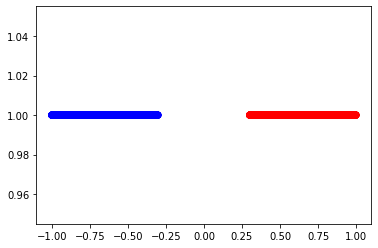

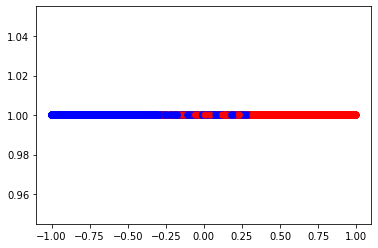

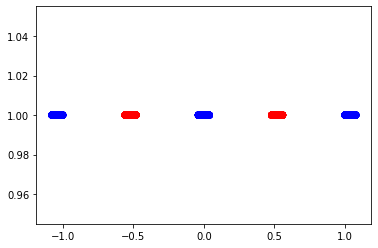

In [ ]:
color = [ "r" if(i >0) else "b" for i in Y]
plt.scatter(x = X_linear, y = np.ones(n_data), c = color)
plt.show()
plt.scatter(x = X_noisy_linear, y = np.ones(n_data), c = color)
plt.show()
plt.scatter(x = X_slab, y = np.ones(n_data), c = color)
plt.show()

In [ ]:
#X, Y = shuffle(X,Y)
def split_data(X,Y):
  x_train = []
  y_train = []

  x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.9)

  x_train = np.array(x_train)
  y_train = np.array(y_train)
  x_val = np.array(x_val)
  y_val = np.array(y_val)
  
  return x_train, y_train, x_val, y_val

In [ ]:
tp = keras.metrics.TruePositives()
tn = keras.metrics.TrueNegatives()
fp = keras.metrics.FalsePositives()
fn = keras.metrics.FalseNegatives()
precision = keras.metrics.Precision()
recall = keras.metrics.Recall()

In [ ]:
def train(x_train, y_train,x_val,y_val, epoch):
  y_mod_train = y_train.copy()
  y_mod_train[y_mod_train == -1] = 0
  y_mod_val = y_val.copy()
  y_mod_val[y_mod_val == -1] = 0

  model = Sequential()
  model.add(keras.layers.InputLayer(input_shape=(x_train.shape[1],)))
  #model.add(keras.layers.Dropout(.1))
  model.add(keras.layers.Dense(100, activation="relu", kernel_regularizer = keras.regularizers.l2(5*1e-7)))
  #model.add(keras.layers.Dense(100, activation="relu", kernel_regularizer = keras.regularizers.l2(5*1e-7)))

  #model.add(keras.layers.Dropout(.1))
  #model.add(keras.layers.Dense(256, activation="relu"))
  #model.add(keras.layers.Dropout(.1))
  model.add(keras.layers.Dense(1, activation="sigmoid"))
  #model.build(input_shape=(1,11))

  model.compile(optimizer=keras.optimizers.SGD(learning_rate=.1),
                loss=keras.losses.binary_crossentropy, metrics = ["accuracy"])#,tp,tn,fp,fn,precision,recall])
  model.fit(x_train, y_mod_train,batch_size=256, epochs=epoch, validation_data=(x_val,y_mod_val))

  return model

In [ ]:
def get_logit_distribution(model, x_val,y_val):
  model.layers[-1].activation = None
  pred = model.predict(x_val)
  #print(len(pred))
  print("AUC : ",roc_auc_score(y_val,pred))
  bool_x = y_val == 1
  #plt.hist(pred[bool_x], 50, facecolor=None, alpha=0.5, edgecolor = "blue")
  #plt.show()
  return pred[bool_x]

In [ ]:
def plot_hist(original, modified, label):
  bins = np.linspace(-50, 50, 100)
  plt.hist(original, bins, alpha=0.5, label='Original')
  plt.hist(modified, bins, alpha=0.5, label=label)
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
def plot_decision_boundary(X,Y, model):
  X_reduced = X[:,:2]
  #x_train, y_train, x_val, y_val = split_data(X_reduced,Y)
  #model = train(x_train, y_train, x_val, y_val)

  h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].    
  x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
  y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    

  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                        np.arange(y_min, y_max, 0.1))
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

  # Plotting
  plt.scatter(X[:,0], X[:,1], c= Y)
  plt.contourf(xx, yy, Z, alpha=0.4)
  plt.scatter(X[:, 0], X[:, 1],c = Y, alpha=0.8)
  plt.xlabel("S",fontsize=15)
  plt.ylabel("Sc",fontsize=15)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.show()


In [ ]:
gamma = .1
B = 1
p = .1
n_features = 2

Results on LMS-5 Dataset

In [ ]:
k= 5

In [ ]:
X = []
X.append(gen_linear(gamma, B))
for i in range(n_features-1):
  X.append(gen_slab(gamma,B,k))
X = np.array(X)
X = X.transpose()

In [ ]:
#Original 
x_train, y_train, x_val, y_val = split_data(X,Y)
model = train(x_train, y_train, x_val, y_val, 10)
original_logit_dist = get_logit_distribution(model,x_val,y_val)

Epoch 1/10
18/18 [==============================] - 2s 13ms/step - loss: 0.6107 - accuracy: 0.9702 - val_loss: 0.5210 - val_accuracy: 1.0000
Epoch 2/10
18/18 [==============================] - 0s 3ms/step - loss: 0.4255 - accuracy: 1.0000 - val_loss: 0.3245 - val_accuracy: 1.0000
Epoch 3/10
18/18 [==============================] - 0s 4ms/step - loss: 0.2463 - accuracy: 1.0000 - val_loss: 0.1804 - val_accuracy: 1.0000
Epoch 4/10
18/18 [==============================] - 0s 3ms/step - loss: 0.1402 - accuracy: 1.0000 - val_loss: 0.1109 - val_accuracy: 1.0000
Epoch 5/10
18/18 [==============================] - 0s 3ms/step - loss: 0.0902 - accuracy: 1.0000 - val_loss: 0.0771 - val_accuracy: 1.0000
Epoch 6/10
18/18 [==============================] - 0s 3ms/step - loss: 0.0646 - accuracy: 1.0000 - val_loss: 0.0584 - val_accuracy: 1.0000
Epoch 7/10
18/18 [==============================] - 0s 3ms/step - loss: 0.0498 - accuracy: 1.0000 - val_loss: 0.0466 - val_accuracy: 1.0000
Epoch 8/10
18/18 [=

In [ ]:
'''
#model.layers[-1].activation = None
y_mod_val = y_val.copy()
y_mod_val[y_mod_val == -1] = 0
pred = model.predict(x_val)
print(roc_auc_score(y_mod_val,pred))
model.evaluate(x_val,y_mod_val)
'''

'\n#model.layers[-1].activation = None\ny_mod_val = y_val.copy()\ny_mod_val[y_mod_val == -1] = 0\npred = model.predict(x_val)\nprint(roc_auc_score(y_mod_val,pred))\nmodel.evaluate(x_val,y_mod_val)\n'

In [ ]:
#Linear(S) Randomized
X_LR = X.copy()
X_LR[:,0] = shuffle(X_LR[:,0])
x_train, y_train, x_val, y_val = split_data(X_LR,Y)
#model = train(x_train, y_train, x_val, y_val)
LR_logit_dist = get_logit_distribution(model,x_val, y_val)

AUC :  0.5062724014336918


In [ ]:
#S complement  Randomized
X_CR = X.copy()
X_CR[:,1:-1] = shuffle(X_CR[:,1:-1])
x_train, y_train, x_val, y_val = split_data(X_CR,Y)
#model = train(x_train, y_train, x_val, y_val)
CR_logit_dist = get_logit_distribution(model,x_val,y_val)

AUC :  1.0


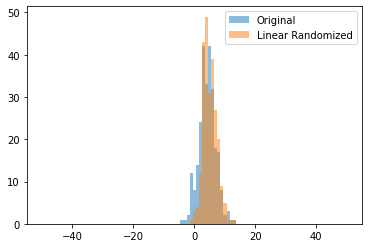

In [ ]:
plot_hist(original_logit_dist,LR_logit_dist, "Linear Randomized")

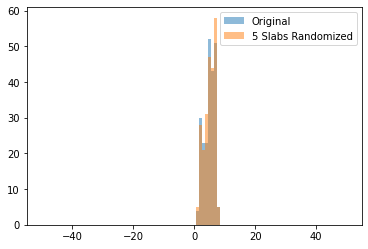

In [ ]:
plot_hist(original_logit_dist,CR_logit_dist, "5 Slabs Randomized")

In [ ]:
X_reduced = X[:,:2]
x_train, y_train, x_val, y_val = split_data(X_reduced,Y)
model = train(x_train, y_train, x_val, y_val,10)

Epoch 1/10
18/18 [==============================] - 0s 10ms/step - loss: 0.6323 - accuracy: 0.8522 - val_loss: 0.5521 - val_accuracy: 1.0000
Epoch 2/10
18/18 [==============================] - 0s 3ms/step - loss: 0.4655 - accuracy: 0.9996 - val_loss: 0.3723 - val_accuracy: 1.0000
Epoch 3/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2842 - accuracy: 1.0000 - val_loss: 0.2128 - val_accuracy: 1.0000
Epoch 4/10
18/18 [==============================] - 0s 4ms/step - loss: 0.1614 - accuracy: 1.0000 - val_loss: 0.1286 - val_accuracy: 1.0000
Epoch 5/10
18/18 [==============================] - 0s 3ms/step - loss: 0.1014 - accuracy: 1.0000 - val_loss: 0.0864 - val_accuracy: 1.0000
Epoch 6/10
18/18 [==============================] - 0s 3ms/step - loss: 0.0712 - accuracy: 1.0000 - val_loss: 0.0632 - val_accuracy: 1.0000
Epoch 7/10
18/18 [==============================] - 0s 3ms/step - loss: 0.0541 - accuracy: 1.0000 - val_loss: 0.0495 - val_accuracy: 1.0000
Epoch 8/10
18/18 [=

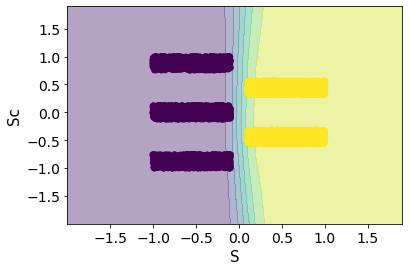

In [ ]:
plot_decision_boundary(X,Y,model)

Results on MS-5 Dataset

In [ ]:
def get_orthonormal_matrix(n):
    H = np.random.randn(n, n)
    s = np.linalg.svd(H)[1]
    s = s[s>1e-7]
    if len(s) != n: return get_orthonormal_matrix(n)
    Q, R = qr(H)
    return Q

In [ ]:
k1 = 5
k2 = 7
gamma = .1
n_features = 50
B = 1

In [ ]:

X_MS = []
X_MS.append(gen_slab(gamma,B,k1))
for i in range(n_features-1):
  X_MS.append(gen_slab(gamma,B,k2))
X_MS = np.array(X_MS)
X_MS = X_MS.transpose()

In [ ]:
#X = X.dot(get_orthonormal_matrix(n_features))

In [ ]:
#Original 
x_train, y_train, x_val, y_val = split_data(X_MS,Y)
model = train(x_train, y_train, x_val, y_val,180)
original_logit_dist = get_logit_distribution(model,x_val, y_val)

Epoch 1/180
18/18 [==============================] - 0s 9ms/step - loss: 0.7207 - accuracy: 0.5009 - val_loss: 0.6650 - val_accuracy: 0.5820
Epoch 2/180
18/18 [==============================] - 0s 3ms/step - loss: 0.6849 - accuracy: 0.5156 - val_loss: 0.6444 - val_accuracy: 0.5900
Epoch 3/180
18/18 [==============================] - 0s 3ms/step - loss: 0.6626 - accuracy: 0.5542 - val_loss: 0.6277 - val_accuracy: 0.6340
Epoch 4/180
18/18 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.5976 - val_loss: 0.6131 - val_accuracy: 0.6680
Epoch 5/180
18/18 [==============================] - 0s 3ms/step - loss: 0.6254 - accuracy: 0.6416 - val_loss: 0.6001 - val_accuracy: 0.7080
Epoch 6/180
18/18 [==============================] - 0s 3ms/step - loss: 0.6091 - accuracy: 0.6944 - val_loss: 0.5862 - val_accuracy: 0.7240
Epoch 7/180
18/18 [==============================] - 0s 3ms/step - loss: 0.5938 - accuracy: 0.7224 - val_loss: 0.5741 - val_accuracy: 0.7560
Epoch 8/180
1

In [ ]:
#Linear(S) Randomized
X_LR = X_MS.copy()
X_LR[:,0] = shuffle(X_LR[:,0])
x_train, y_train, x_val, y_val = split_data(X_LR,Y)
#model = train(x_train, y_train, x_val, y_val)
LR_logit_dist = get_logit_distribution(model,x_val, y_val)

AUC :  0.9999519877088535


In [ ]:
#S complement  Randomized
X_CR = X_MS.copy()
for i in range(n_features-1):
  X_CR[:,i+1] = shuffle(X_CR[:,i+1])
x_train, y_train, x_val, y_val = split_data(X_CR,Y)
#model = train(x_train, y_train, x_val, y_val)
CR_logit_dist = get_logit_distribution(model,x_val, y_val)

AUC :  0.542386712749616


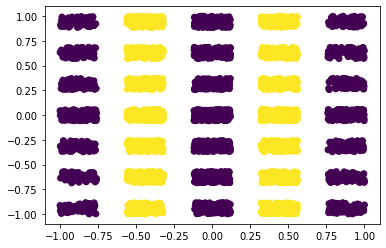

In [ ]:
plt.scatter(X_CR[:,0], X_CR[:,1], c= Y)

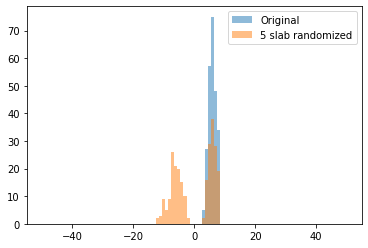

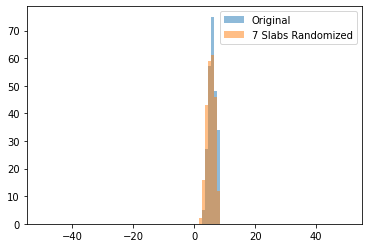

In [ ]:
plot_hist(original_logit_dist,LR_logit_dist, "5 slab randomized")
plot_hist(original_logit_dist,CR_logit_dist, "7 Slabs Randomized")

In [ ]:
'''
X_MS_test = X_MS.copy()
#X_MS_test[:,0] = np.zeros(50000)#np.zeros(shape=(len(X_MS_test),49))
X_MS_test[:,1:] = np.zeros(shape=(len(X_MS_test),49))

#model.layers[-1].activation = 
y_mod = Y.copy()
y_mod[y_mod == -1] = 0
pred = model.predict(X_MS_test)

model.evaluate(X_MS_test,y_mod)
'''

'\nX_MS_test = X_MS.copy()\n#X_MS_test[:,0] = np.zeros(50000)#np.zeros(shape=(len(X_MS_test),49))\nX_MS_test[:,1:] = np.zeros(shape=(len(X_MS_test),49))\n\n#model.layers[-1].activation = \ny_mod = Y.copy()\ny_mod[y_mod == -1] = 0\npred = model.predict(X_MS_test)\n\nmodel.evaluate(X_MS_test,y_mod)\n'

In [ ]:
X_reduced = X_CR[:,:2]
x_train, y_train, x_val, y_val = split_data(X_reduced,Y)
model = train(x_train, y_train, x_val, y_val,100)

Epoch 1/100
18/18 [==============================] - 0s 9ms/step - loss: 0.6932 - accuracy: 0.5587 - val_loss: 0.6889 - val_accuracy: 0.6200
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.6051 - val_loss: 0.6865 - val_accuracy: 0.6080
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6868 - accuracy: 0.6253 - val_loss: 0.6844 - val_accuracy: 0.7080
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.7027 - val_loss: 0.6826 - val_accuracy: 0.7100
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6822 - accuracy: 0.7209 - val_loss: 0.6809 - val_accuracy: 0.5880
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.6760 - val_loss: 0.6793 - val_accuracy: 0.6680
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.7078 - val_loss: 0.6772 - val_accuracy: 0.6600
Epoch 8/100
1

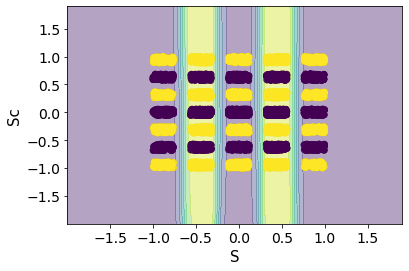

In [ ]:
plot_decision_boundary(X_LR,Y,model)

11501568/11490434 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


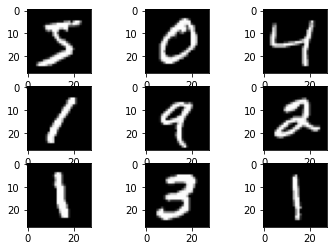

In [ ]:

from keras.datasets import mnist
from matplotlib import pyplot
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

In [ ]:
m_X= np.concatenate((trainX, testX), axis = 0)
m_Y = np.concatenate((trainy, testy))

m_temp_X = np.ndarray(shape=(len(m_X), 32, 32,3))
for i in range(len(m_X)):
  temp = np.pad(m_X[i],(2))
  temp = np.stack((temp,)*3, axis=-1)
  m_temp_X[i] = temp
m_X = m_temp_X

bool_mask_0 = m_Y == 1 #np.logical_or(m_Y == 0, m_Y == 1)
bool_mask_1 = m_Y == 4
bool_mask_0 = bool_mask_0.reshape((bool_mask_0.shape[0],))
bool_mask_1 = bool_mask_1.reshape((bool_mask_1.shape[0],))

m_X_0 = m_X[bool_mask_0]
m_X_1 = m_X[bool_mask_1]

m_Y_0 = m_Y[bool_mask_0]
m_Y_1 = m_Y[bool_mask_1]


170508288/170498071 [==============================] - 11s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


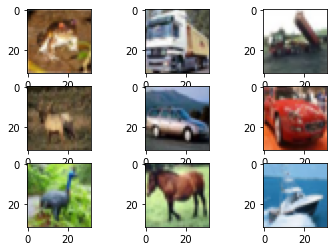

In [ ]:
#Automobile - 1 , Truck 9
from matplotlib import pyplot
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i])
# show the figure
pyplot.show()

In [ ]:
c_X= np.concatenate((trainX, testX))
c_Y = np.concatenate((trainy, testy))

bool_mask_0 = c_Y == 1 #np.logical_or(m_Y == 0, m_Y == 1)
bool_mask_1 = c_Y == 9
bool_mask_0 = bool_mask_0.reshape((bool_mask_0.shape[0],))
bool_mask_1 = bool_mask_1.reshape((bool_mask_1.shape[0],))

c_X_0 = c_X[bool_mask_0]
c_X_1 = c_X[bool_mask_1]

c_Y_0 = c_Y[bool_mask_0]
c_Y_1 = c_Y[bool_mask_1]


In [ ]:
min_class0 =  min(len(m_Y_0),  len(c_Y_0))
min_class1 = min(len(m_Y_1),  len(c_Y_1))

c_X_0 = shuffle(c_X_0)[:min_class0]
c_X_1 = shuffle(c_X_1)[:min_class1]
m_X_0 = shuffle(m_X_0)[:min_class0]
m_X_1 = shuffle(m_X_1)[:min_class1]



In [ ]:
def get_m_c_data(randomization):
  
  #randomization = "NR" for NO Randomization , "SR" for S randomized, "SCR" for #S-Complement  randomized
  
  if randomization == "NR":
    m_c_X_0 = np.ndarray(shape=(min_class0, 64, 32,3))
    m_c_X_1 = np.ndarray(shape=(min_class1, 64, 32,3))
    for i in range(min_class0):
      temp = np.concatenate((m_X_0[i], c_X_0[i]), axis = 0)
      m_c_X_0[i] = temp

    for i in range(min_class1):
      temp = np.concatenate((m_X_1[i], c_X_1[i]))
      m_c_X_1[i] = temp

    m_c_X = np.concatenate((m_c_X_0,m_c_X_1))
    Y = np.concatenate(([0]*min_class0, [1]*min_class1))

  
  elif randomization == "SR":
    c_X = np.concatenate((c_X_0,c_X_1))
    Y = np.concatenate(([0]*min_class0, [1]*min_class1))
    m_X = shuffle(np.concatenate((m_X_0,m_X_1)))
    
    m_c_X = np.ndarray(shape=(min_class0+min_class1, 64, 32,3))
    for i in range(min_class0+min_class1):
      temp = np.concatenate((m_X[i], c_X[i]), axis = 0)
      m_c_X[i] = temp
    
    
  elif randomization == "SCR":
    m_X = np.concatenate((m_X_0,m_X_1))
    Y = np.concatenate(([0]*min_class0, [1]*min_class1))
    c_X = shuffle(np.concatenate((c_X_0,c_X_1)))
    
    m_c_X = np.ndarray(shape=(min_class0+min_class1, 64, 32,3))
    for i in range(min_class0+min_class1):
      temp = np.concatenate((m_X[i], c_X[i]), axis = 0)
      m_c_X[i] = temp

  m_c_X = m_c_X.astype(np.int32)
  m_c_X, Y = shuffle(m_c_X, Y)
  #m_c_X = m_c_X/255.0
  return m_c_X, Y



0
1
0
1
1
1
1
1
0


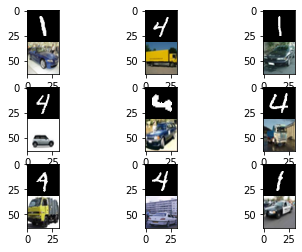

In [ ]:
for i in range(9):
	# define subplot
  pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
  x,y = get_m_c_data("SCR")
  pyplot.imshow(x[i])
  print(y[i])
# show the figure
pyplot.show()

In [ ]:
m_c_X, Y = get_m_c_data("NR")
x_train, x_val, y_train, y_val = train_test_split(m_c_X, Y, train_size=0.9)

In [ ]:
base_model = keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(64, 32, 3),
    include_top=False)

94773248/94765736 [==============================] - 3s 0us/step


In [ ]:
base_model.trainable = False
inputs = keras.Input(shape=(64, 32, 3))
x = keras.layers.experimental.preprocessing.Rescaling(scale=1.0 / 255)(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, kernel_regularizer = keras.regularizers.l2(5*1e-7))(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=.1, momentum=.9),loss=keras.losses.BinaryCrossentropy(from_logits=True),metrics=[keras.metrics.BinaryAccuracy()])
model.fit(x_train,y_train,batch_size = 256, epochs=20)

Epoch 1/20
43/43 [==============================] - 17s 36ms/step - loss: 3.1676 - binary_accuracy: 0.8147
Epoch 2/20
43/43 [==============================] - 1s 33ms/step - loss: 0.3007 - binary_accuracy: 0.9593
Epoch 3/20
43/43 [==============================] - 1s 33ms/step - loss: 0.2333 - binary_accuracy: 0.9664
Epoch 4/20
43/43 [==============================] - 1s 33ms/step - loss: 0.1989 - binary_accuracy: 0.9638
Epoch 5/20
43/43 [==============================] - 1s 33ms/step - loss: 0.1698 - binary_accuracy: 0.9681
Epoch 6/20
43/43 [==============================] - 1s 33ms/step - loss: 0.2709 - binary_accuracy: 0.9480
Epoch 7/20
43/43 [==============================] - 1s 33ms/step - loss: 0.1128 - binary_accuracy: 0.9778
Epoch 8/20
43/43 [==============================] - 1s 33ms/step - loss: 0.1193 - binary_accuracy: 0.9744
Epoch 9/20
43/43 [==============================] - 1s 33ms/step - loss: 0.0822 - binary_accuracy: 0.9800
Epoch 10/20
43/43 [==========================

In [ ]:
original_logit_dist = get_logit_distribution(model,m_c_X,Y)

AUC :  0.9974373611111111


S(MNIST) Randomized

AUC :  0.5210886805555556


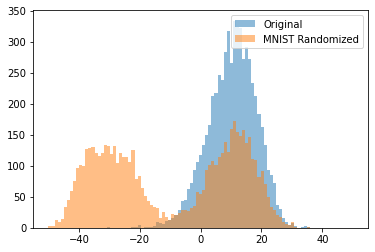

In [ ]:
m_c_X, Y = get_m_c_data("SR")
LR_logit_dist = get_logit_distribution(model,m_c_X,Y)
plot_hist(original_logit_dist,LR_logit_dist, "MNIST Randomized")

SC(CIFAR) Randomized

AUC :  0.996929


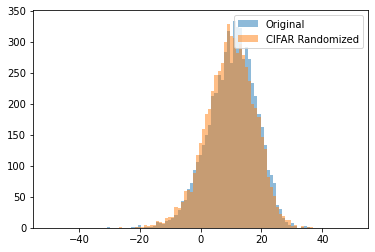

In [ ]:
m_c_X, Y = get_m_c_data("SCR")
LR_logit_dist = get_logit_distribution(model,m_c_X,Y)
plot_hist(original_logit_dist,LR_logit_dist, "CIFAR Randomized")